# LIBRARY IMPORTS

In [ ]:
import pandas as pd
from warnings import warn
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.stats import kurtosis, skew

from neurokit2.misc import NeuroKitWarning, as_vector
from neurokit2.signal import signal_filter
import sys
sys.path.append("C:/Users/AmitDebnath/OneDrive - TVAM TECHNOLOGIES PRIVATE LIMITED/Desktop/test/RAG/Python codes/EDA Project/Notebooks/Testing files for neurokit/EDA_Analyzer_TVAM")

from EDA_Analyzer_TVAM import eda_findpeaks
from EDA_Analyzer_TVAM.eda_findpeaks import eda_findpeaks
from EDA_Analyzer_TVAM.eda_fixpeaks import eda_fixpeaks
from EDA_Analyzer_TVAM.eda_clean import _eda_clean_missing, _eda_clean_biosppy, _eda_clean_neurokit
from neurokit2.signal import signal_filter, signal_findpeaks, signal_smooth, signal_zerocrossings
from neurokit2.signal.signal_formatpeaks import _signal_formatpeaks_sanitize

from neurokit2.signal import signal_sanitize
from neurokit2.misc.report import create_report
from EDA_Analyzer_TVAM.eda_methods import eda_methods
from EDA_Analyzer_TVAM.eda_peaks import eda_peaks

# DATA LOADING

In [67]:
# Load the local CSV file using pandas
data = pd.read_csv(r"C:\Users\AmitDebnath\Downloads\Kaggle dataset and ground truth\p20_1280_rows_value.csv")

# Extract the single column as 1D array
eda_signal = data.iloc[:, 0].values

# PRE PROCESSING

1. eda_clean

In [ ]:
# Handle missing data by replacing with zero   Instead of na=0 remove all the na values
n_missing = np.sum(np.isnan(eda_signal))
if n_missing > 0:
    warn(
        "There are " + str(n_missing) + " missing data points in your signal. "
        "Filling missing values with 0.",
        category=NeuroKitWarning,
    )
    # Fill missing values with zero
    eda_signal = pd.Series(eda_signal).fillna(0)

eda_signal_missing = pd.Series(eda_signal).fillna(0).values


In [70]:
# Ensure EDA signal is in vector form
eda_signal = as_vector(eda_signal)
method = "neurokit"

In [ ]:
# Choose and apply cleaning method
sampling_rate = 128

clean = signal_filter(
    eda_signal,
    sampling_rate=sampling_rate,
    highcut=61.5,           # Low-pass at 61.5 Hz
    method="butterworth", # 4th order Butterworth
    order=4
)

In [72]:
eda_cleaned = clean

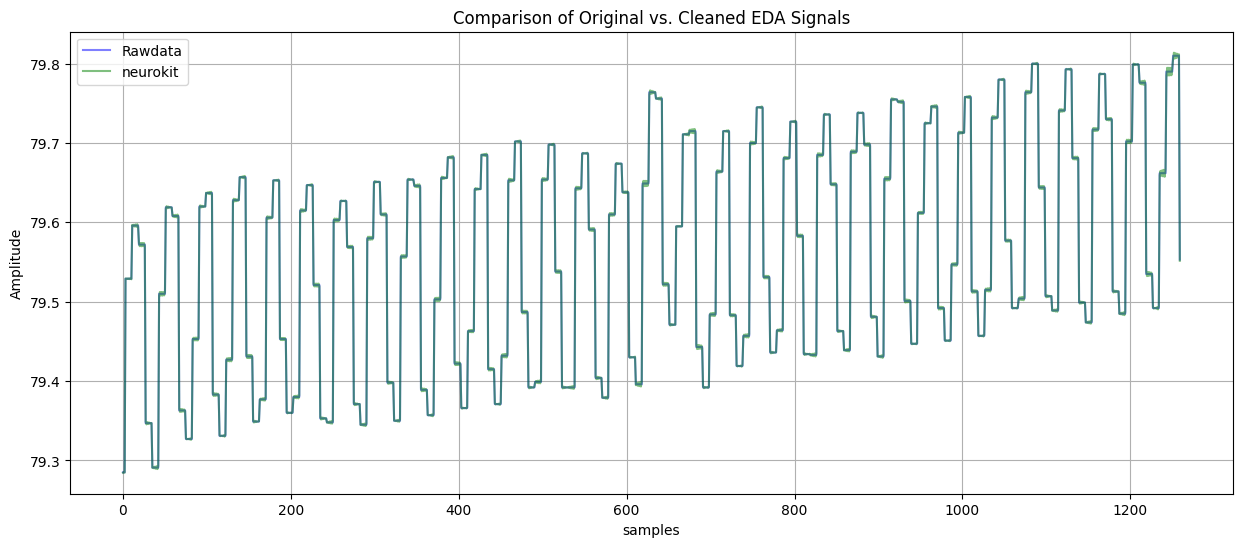

In [73]:
# 6. Plot BOTH signals against their respective time axes
plt.figure(figsize=(15, 6))
plt.plot( eda_signal, label="Rawdata", color='blue', alpha=0.5)
plt.plot(eda_cleaned, label="neurokit", color='green', alpha=0.5)  # use time axis here


plt.title('Comparison of Original vs. Cleaned EDA Signals')
plt.xlabel('samples') # Make it as a time axis later 
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
all_results = []
sampling_rate = 128
window_end = 1260
raw_eda_full = eda_cleaned

for start_point in range(window_end):
    raw_eda_window = raw_eda_full[start_point:window_end]
    print(f"Processing slice: {start_point} to {window_end}")
    
    if len(raw_eda_window) > 0:
        feature_row = {
            "start_index": start_point,
            "end_index": window_end,
            "mean": np.nanmean(raw_eda_window),
            "max": np.nanmax(raw_eda_window),
            "min": np.nanmin(raw_eda_window),
            "range": np.nanmax(raw_eda_window) - np.nanmin(raw_eda_window),
            "kurtosis":kurtosis(raw_eda_window),
            "skewness":skew(raw_eda_window),
        }
        all_results.append(feature_row)

# Combine all the reuults into one dataframe
final_results = pd.DataFrame(all_results)
print("EDA feature extracted completed.")

# Save to csv file
output_path = r"C:\Users\AmitDebnath\Downloads\EDA_Features_results.csv"
final_results.to_csv(output_path, index=False)
print(f"Results saved to: {output_path}")

Processing slice: 0 to 1260
Processing slice: 1 to 1260
Processing slice: 2 to 1260
Processing slice: 3 to 1260
Processing slice: 4 to 1260
Processing slice: 5 to 1260
Processing slice: 6 to 1260
Processing slice: 7 to 1260
Processing slice: 8 to 1260
Processing slice: 9 to 1260
Processing slice: 10 to 1260
Processing slice: 11 to 1260
Processing slice: 12 to 1260
Processing slice: 13 to 1260
Processing slice: 14 to 1260
Processing slice: 15 to 1260
Processing slice: 16 to 1260
Processing slice: 17 to 1260
Processing slice: 18 to 1260
Processing slice: 19 to 1260
Processing slice: 20 to 1260
Processing slice: 21 to 1260
Processing slice: 22 to 1260
Processing slice: 23 to 1260
Processing slice: 24 to 1260
Processing slice: 25 to 1260
Processing slice: 26 to 1260
Processing slice: 27 to 1260
Processing slice: 28 to 1260
Processing slice: 29 to 1260
Processing slice: 30 to 1260
Processing slice: 31 to 1260
Processing slice: 32 to 1260
Processing slice: 33 to 1260
Processing slice: 34 to 

2. eda_phasic (baseline_als method)

In [9]:
# Initialize ALS parameters

lam = 1e3   # smoothness
p = 0.001    # asymmetry
niter = 10  # number of iterations

In [10]:
L = len(eda_signal)
D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
w = np.ones(L)

# Check the sparse difference matrix
print("Difference matrix shape:", D.shape)

Difference matrix shape: (1260, 1258)


In [11]:
# Run the ALS iterations

for i in range(niter):
    # Build weighted diagonal matrix
    W = sparse.spdiags(w, 0, L, L)
    
    # Solve the weighted least squares problem
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w * eda_signal)
    
    # Update weights asymmetrically
    w = p * (eda_signal > z) + (1 - p) * (eda_signal < z)


In [12]:
# Extract tonic and phasic

tonic_baseline_als = z
print(np.shape(tonic_baseline_als),np.shape(eda_signal))
phasic_baseline_als = eda_signal - tonic_baseline_als
print(np.shape(phasic_baseline_als))

# Inspect
print("Tonic length:", len(tonic_baseline_als))
print("Phasic length:", len(phasic_baseline_als))


(1260,) (1260,)
(1260,)
Tonic length: 1260
Phasic length: 1260


SUBPLOT FOR BASELINE ALS METHOD

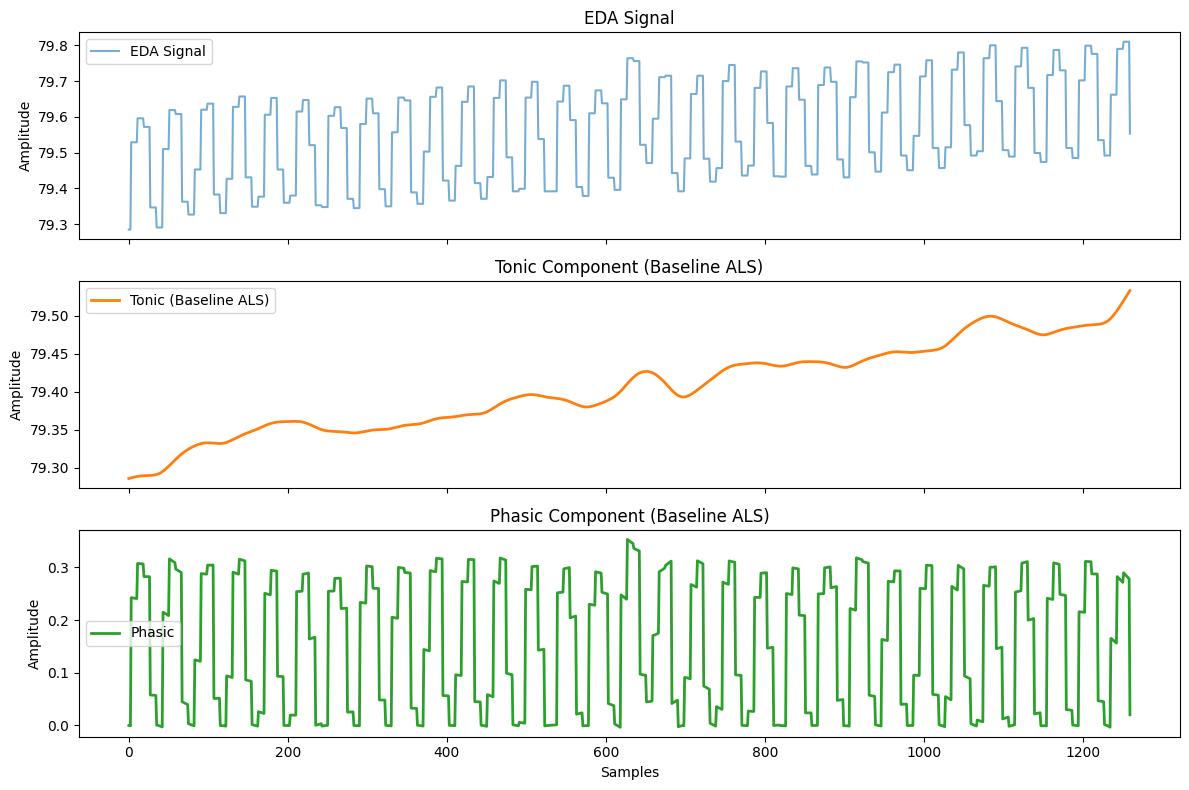

In [19]:
import matplotlib.pyplot as plt

# Create 3 vertically stacked subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 1️⃣ Raw EDA Signal
axs[0].plot(eda_signal, label="EDA Signal", alpha=0.6, color='tab:blue')
axs[0].set_ylabel("Amplitude")
axs[0].set_title("EDA Signal")
axs[0].legend()

# 2️⃣ Tonic Component (Baseline ALS)
axs[1].plot(tonic_baseline_als, label="Tonic (Baseline ALS)", linewidth=2, color='tab:orange')
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Tonic Component (Baseline ALS)")
axs[1].legend()

# 3️⃣ Phasic Component (Baseline ALS)
axs[2].plot(phasic_baseline_als.T, label="Phasic", linewidth=2, color='tab:green')
axs[2].set_xlabel("Samples")
axs[2].set_ylabel("Amplitude")
axs[2].set_title("Phasic Component (Baseline ALS)")
axs[2].legend()

# Optimize layout
plt.tight_layout()
plt.show()


3. eda_findpeaks

In [23]:
# Main baseline_als function
def baseline_als(eda_signal, lam=1e3, p=0.001, niter=10):
    """
    Asymmetric Least Squares baseline estimation for EDA tonic/phasic decomposition
    Reference: Eilers & Boelens (2005)
    
    Parameters
    ----------
    eda_signal : array
        Input EDA signal
    lam : float
        Smoothness parameter (higher = smoother baseline)
    p : float
        Asymmetry parameter (0 < p < 1)
    niter : int
        Number of iterations
        
    Returns
    -------
    tonic : array
        Estimated tonic (baseline) component
    phasic : array
        Phasic component = eda_signal - tonic
    """
    L = len(eda_signal)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)

    # Check the sparse difference matrix
    print("Difference matrix shape:", D.shape)

    for i in range(niter):
        # Build weighted diagonal matrix
        W = sparse.spdiags(w, 0, L, L)
        
        # Solve the weighted least squares problem
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * eda_signal)

        # Update weights asymmetrically: p where eda > baseline, (1-p) otherwise
        w = p * (eda_signal > z) + (1.0 - p) * (eda_signal <= z)

    # Extract tonic and phasic
    tonic = z
    phasic = eda_signal - tonic

    # Inspect
    print("Tonic length:", len(tonic))
    print("Phasic length:", len(phasic))

    return tonic, phasic


In [24]:
# Clean and extract phasic component using baseline_als (no sampling_rate argument)
# eda_cleaned = eda_cleaned(eda_signal, sampling_rate=sampling_rate)

# baseline_als returns (tonic, phasic) arrays
tonic, phasic = baseline_als(eda_cleaned)

# PLOT PHASIC, TONIC, EDA_CLEANED

# If downstream cells expect a DataFrame with columns 'EDA_Tonic' and 'EDA_Phasic',
# create eda_dict accordingly and extract the phasic values.
eda_dict = pd.DataFrame({"EDA_Tonic": tonic, "EDA_Phasic": phasic})
eda_phasic_cvxeda = eda_dict["EDA_Phasic"].values

Difference matrix shape: (1260, 1258)
Tonic length: 1260
Phasic length: 1260


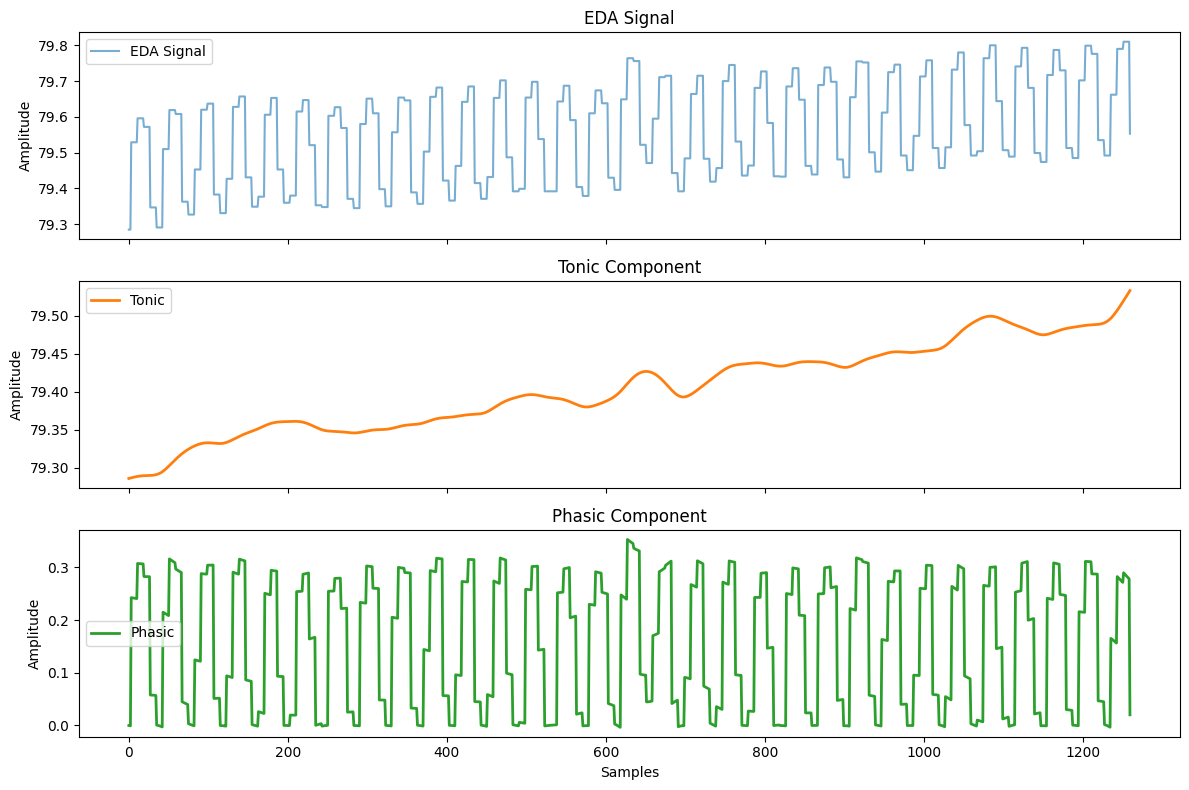

In [25]:
import matplotlib.pyplot as plt

# Create 3 vertically stacked subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 1️⃣ Raw EDA Signal
axs[0].plot(eda_signal, label="EDA Signal", alpha=0.6, color='tab:blue')
axs[0].set_ylabel("Amplitude")
axs[0].set_title("EDA Signal")
axs[0].legend()

# 2️⃣ Tonic Component
axs[1].plot(tonic_baseline_als, label="Tonic", linewidth=2, color='tab:orange')
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Tonic Component")
axs[1].legend()

# 3️⃣ Phasic Component
axs[2].plot(phasic_baseline_als, label="Phasic", linewidth=2, color='tab:green')
axs[2].set_xlabel("Samples")
axs[2].set_ylabel("Amplitude")
axs[2].set_title("Phasic Component")
axs[2].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()


# METHOD = 'gamboa2008' with baseline_als function

In [30]:
method = "gamboa2008"
amplitude_min = 0.1

In [31]:
# STEP 5: Gamboa (2008) method
# ================================================================
if method in ["gamboa2008", "gamboa"]:
    derivative = np.diff(np.sign(np.diff(eda_phasic_cvxeda)))

    pi = np.nonzero(derivative < 0)[0] + 1  # maxima
    ni = np.nonzero(derivative > 0)[0] + 1  # minima

    if len(pi) == 0 or len(ni) == 0:
        raise ValueError("Could not find enough SCR peaks.")

    if ni[0] < pi[0]:
        ni = ni[1:]
    if pi[-1] > ni[-1]:
        pi = pi[:-1]
    if len(pi) > len(ni):
        pi = pi[:-1]

    li = min(len(pi), len(ni))
    peaks = pi[:li]
    onsets = ni[:li]
    amplitudes = np.array([np.max(eda_phasic_cvxeda[peaks[i] : onsets[i]]) for i in range(li)])

    SCR_Onsets_gamboa = onsets
    SCR_Peaks_gamboa = peaks
    SCR_Height_gamboa = amplitudes

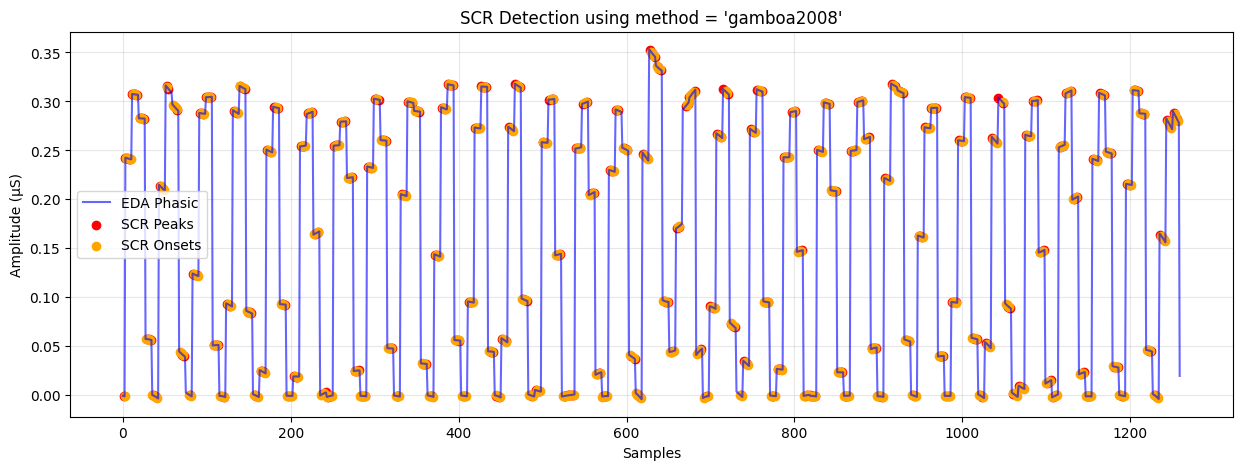

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(phasic_baseline_als, label="EDA Phasic", color="blue", alpha=0.6)

# Ensure SCR_Peaks are integer indices
scr_peaks_idx = np.asarray(SCR_Peaks_gamboa)
if scr_peaks_idx.dtype.kind != "i":
	scr_peaks_idx = scr_peaks_idx.astype(int)

# SCR_Onsets may contain NaNs and/or floats -> remove NaNs and convert to int
scr_onsets_arr = np.asarray(SCR_Onsets_gamboa)
valid_onset_mask = ~np.isnan(scr_onsets_arr)
scr_onsets_idx = scr_onsets_arr[valid_onset_mask].astype(int)

# Plot peaks and onsets using integer indices
plt.scatter(scr_peaks_idx, phasic_baseline_als[scr_peaks_idx], color="red", label="SCR Peaks")
plt.scatter(scr_onsets_idx, phasic_baseline_als[scr_onsets_idx], color="orange", label="SCR Onsets")

plt.title(f"SCR Detection using method = '{method}'")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µS)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

eda_peaks

In [39]:
# STEP 3: Detect SCR peaks using your desired method
# ================================================================
# Step 3a: Find raw peaks
info = eda_findpeaks(phasic_baseline_als, sampling_rate=sampling_rate, method=method, amplitude_min=amplitude_min)

# Step 3b: Fix peaks
info = eda_fixpeaks(info)
print(info)

{'SCR_Onsets': array([  10,   42,   50,   82,   90,   98,  100,  107,  122,  130,  138,
        162,  170,  178,  202,  208,  227,  235,  243,  267,  275,  290,
        298,  330,  338,  370,  378,  386,  410,  418,  426,  450,  458,
        466,  490,  498,  506,  515,  523,  555,  563,  571,  578,  586,
        618,  626,  651,  683,  691,  698,  706,  714,  738,  746,  754,
        778,  786,  791,  803,  811,  819,  826,  834,  855,  859,  883,
        891,  899,  906,  914,  946,  954,  962,  966,  971,  979,  986,
        994, 1002, 1026, 1034, 1042, 1066, 1074, 1082, 1084, 1091, 1099,
       1107, 1131, 1139, 1147, 1154, 1162, 1194, 1202, 1234, 1242, 1250]), 'SCR_Peaks': array([   3,   11,   43,   51,   83,   91,   99,  106,  114,  123,  131,
        139,  163,  171,  179,  203,  226,  234,  242,  266,  274,  282,
        291,  299,  331,  339,  371,  379,  387,  411,  419,  427,  451,
        459,  467,  491,  499,  514,  522,  554,  562,  570,  576,  579,
        587,  619,  6

In [77]:
# STEP 4: Compute additional features: amplitude, rise time, recovery
# ================================================================
# Peaks and onsets validity
valid_peaks = np.logical_and(info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]),
                             ~np.isnan(info["SCR_Onsets"]))
peaks = info["SCR_Peaks"][valid_peaks]

valid_onsets = ~np.isnan(info["SCR_Onsets"])
valid_onsets[valid_onsets] = info["SCR_Onsets"][valid_onsets] < np.nanmax(info["SCR_Peaks"])
onsets = info["SCR_Onsets"][valid_onsets].astype(int)
print(len(peaks))
print(onsets)

98
[  10   42   50   82   90   98  100  107  122  130  138  162  170  178
  202  208  227  235  243  267  275  290  298  330  338  370  378  386
  410  418  426  450  458  466  490  498  506  515  523  555  563  571
  578  586  618  626  651  683  691  698  706  714  738  746  754  778
  786  791  803  811  819  826  834  855  859  883  891  899  906  914
  946  954  962  966  971  979  986  994 1002 1026 1034 1042 1066 1074
 1082 1084 1091 1099 1107 1131 1139 1147 1154 1162 1194 1202 1234 1242]


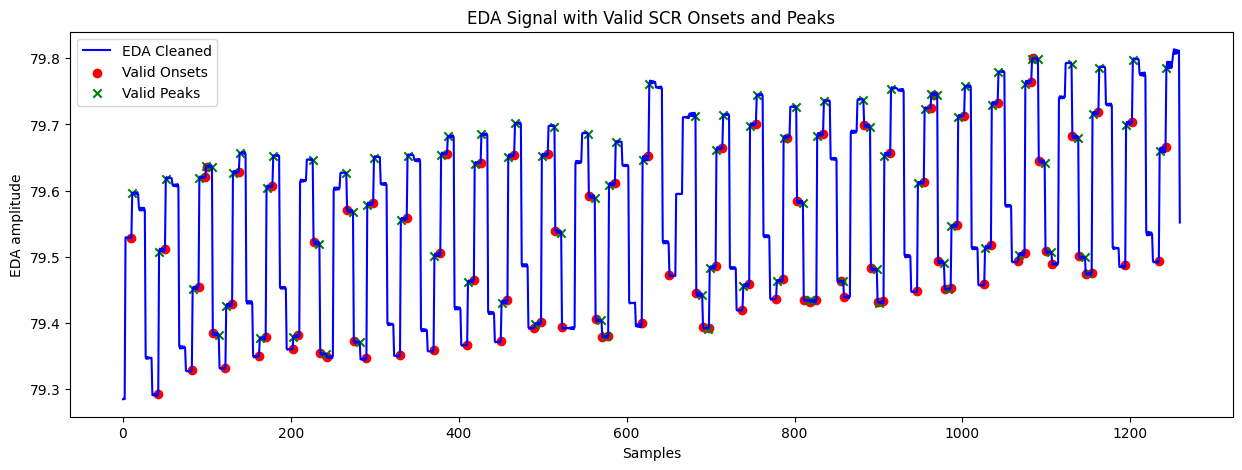

In [44]:
# Plot the cleaned EDA signal
plt.figure(figsize=(15, 5))
plt.plot(eda_cleaned, label="EDA Cleaned", color="blue")

# Mark valid onsets
plt.scatter(onsets, eda_cleaned[onsets], color="red", marker="o", label="Valid Onsets")

# Optional: mark valid peaks as well
plt.scatter(peaks, eda_cleaned[peaks], color="green", marker="x", label="Valid Peaks")

plt.xlabel("Samples")
plt.ylabel("EDA amplitude")
plt.title("EDA Signal with Valid SCR Onsets and Peaks")
plt.legend()
plt.show()


# Finding out the onsets values

In [78]:
results = []

onsets_array = onsets

for start_point in range(window_end):
    print(f"Processing slice: {start_point} to {window_end}")
    
    onset_window = [o for o in onsets_array if start_point <= o <window_end]
    
    MEAN_Onsets = np.mean(onset_window) if len(onset_window) > 0 else np.nan
    MIN_Onsets = np.min(onset_window) if len(onset_window) > 0 else np.nan
    MAX_Onsets = np.max(onset_window) if len(onset_window) > 0 else np.nan
    STD_Onsets = np.std(onset_window) if len(onset_window) > 0 else np.nan
    
    feature_row = {
        "MIN_Onsets": MIN_Onsets,
        "MAX_Onsets": MAX_Onsets,
        "MEAN_Onsets": MEAN_Onsets,
        "STD_Onsets": STD_Onsets
    }
    
    results.append(feature_row)

# Combine all the results and save them to a CSV file
final_results_onsets = pd.DataFrame(results)
output_path_onsets = r"C:\Users\AmitDebnath\Downloads\EDA_onset_features.csv"
final_results_onsets.to_csv(output_path_onsets, index=False)
print(f"Onset features saved to: {output_path_onsets}")

Processing slice: 0 to 1260
Processing slice: 1 to 1260
Processing slice: 2 to 1260
Processing slice: 3 to 1260
Processing slice: 4 to 1260
Processing slice: 5 to 1260
Processing slice: 6 to 1260
Processing slice: 7 to 1260
Processing slice: 8 to 1260
Processing slice: 9 to 1260
Processing slice: 10 to 1260
Processing slice: 11 to 1260
Processing slice: 12 to 1260
Processing slice: 13 to 1260
Processing slice: 14 to 1260
Processing slice: 15 to 1260
Processing slice: 16 to 1260
Processing slice: 17 to 1260
Processing slice: 18 to 1260
Processing slice: 19 to 1260
Processing slice: 20 to 1260
Processing slice: 21 to 1260
Processing slice: 22 to 1260
Processing slice: 23 to 1260
Processing slice: 24 to 1260
Processing slice: 25 to 1260
Processing slice: 26 to 1260
Processing slice: 27 to 1260
Processing slice: 28 to 1260
Processing slice: 29 to 1260
Processing slice: 30 to 1260
Processing slice: 31 to 1260
Processing slice: 32 to 1260
Processing slice: 33 to 1260
Processing slice: 34 to 

# For peaks

In [82]:
results = []

peaks_array = peaks

for start_point in range(window_end):
    print(f"Processing slice: {start_point} to {window_end}")
    
    peaks_window = [o for o in peaks_array if start_point <= o <window_end]
    
    MEAN_Peaks = np.mean(peaks_window) if len(peaks_window) > 0 else np.nan
    MIN_Peaks = np.min(peaks_window) if len(peaks_window) > 0 else np.nan
    MAX_Peaks = np.max(peaks_window) if len(peaks_window) > 0 else np.nan
    STD_Peaks = np.std(peaks_window) if len(peaks_window) > 0 else np.nan
    
    feature_row = {
        "MIN_Peaks": MIN_Peaks,
        "MAX_Peaks": MAX_Peaks,
        "MEAN_Peaks": MEAN_Peaks,
        "STD_Peaks": STD_Peaks
    }
    
    results.append(feature_row)

# Combine all the results and save them to a CSV file
final_results_peaks = pd.DataFrame(results)
output_path_peaks = r"C:\Users\AmitDebnath\Downloads\EDA_peaks_features.csv"
final_results_peaks.to_csv(output_path_peaks, index=False)
print(f"Onset features saved to: {output_path_peaks}")

Processing slice: 0 to 1260
Processing slice: 1 to 1260
Processing slice: 2 to 1260
Processing slice: 3 to 1260
Processing slice: 4 to 1260
Processing slice: 5 to 1260
Processing slice: 6 to 1260
Processing slice: 7 to 1260
Processing slice: 8 to 1260
Processing slice: 9 to 1260
Processing slice: 10 to 1260
Processing slice: 11 to 1260
Processing slice: 12 to 1260
Processing slice: 13 to 1260
Processing slice: 14 to 1260
Processing slice: 15 to 1260
Processing slice: 16 to 1260
Processing slice: 17 to 1260
Processing slice: 18 to 1260
Processing slice: 19 to 1260
Processing slice: 20 to 1260
Processing slice: 21 to 1260
Processing slice: 22 to 1260
Processing slice: 23 to 1260
Processing slice: 24 to 1260
Processing slice: 25 to 1260
Processing slice: 26 to 1260
Processing slice: 27 to 1260
Processing slice: 28 to 1260
Processing slice: 29 to 1260
Processing slice: 30 to 1260
Processing slice: 31 to 1260
Processing slice: 32 to 1260
Processing slice: 33 to 1260
Processing slice: 34 to 

In [41]:
# Ensure peaks/onsets match
if len(onsets) != len(peaks):
    raise ValueError("Peaks and onsets don't match, cannot compute amplitude safely.")


In [43]:
# Compute amplitudes
amplitude = np.full(len(info["SCR_Height"]), np.nan)
amplitude[valid_peaks] = info["SCR_Height"][valid_peaks] - phasic_baseline_als[onsets]

print("SCR Amplitudes:", amplitude)

SCR Amplitudes: [           nan 6.68117593e-02 2.18244052e-01 1.07965821e-01
 1.25518178e-01 1.66731965e-01 1.69714821e-02 3.81774255e-04
 5.03332889e-04 9.56586721e-02 2.00469977e-01 2.84900490e-02
 2.75357595e-02 2.28534171e-01 4.66830759e-02 1.99554707e-02
 2.70481629e-01 3.32693240e-03 3.07876889e-03 2.81521130e-01
 8.05259326e-04 5.86834258e-04 2.34821409e-01 7.07817089e-02
 2.06760955e-01 9.67303690e-02 1.45687568e-01 1.52634604e-01
 2.57497524e-02 9.68404165e-02 1.78828869e-01 4.29084137e-02
 6.05058950e-02 2.20327828e-01 4.83819104e-02 6.71573453e-03
 2.54811283e-01 4.47649195e-02 1.58960455e-03 3.01327507e-01
 3.12208513e-03 2.52291707e-03 4.97036719e-04 2.30874640e-01
 6.36684727e-02 2.51909079e-01 1.13800079e-01 2.67808138e-01
 6.32904124e-03 1.82542941e-03 9.18917021e-02 1.79402766e-01
 5.02088669e-02 3.71946272e-02 2.42288837e-01 4.45214712e-02
 2.78837858e-02 2.16930064e-01 4.72821106e-02 1.65805535e-03
 9.89149710e-04 4.42160857e-06 2.51776055e-01 5.07089921e-02
 3.38270

In [46]:
# Compute rise times (seconds)
risetime = np.full(len(info["SCR_Peaks"]), np.nan)
risetime[valid_peaks] = (peaks - onsets) / sampling_rate
print(risetime)

[      nan 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.046875  0.0546875 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.140625  0.0546875 0.0546875 0.1796875 0.0546875
 0.0546875 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0625    0.0546875 0.2421875 0.0546875 0.0546875
 0.0390625 0.0078125 0.0078125 0.0078125 0.0078125 0.2421875 0.0546875
 0.046875  0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0859375 0.0546875 0.0546875 0.0078125 0.0078125
 0.0078125 0.0234375 0.1796875 0.0546875 0.0546875 0.015625  0.0078125
 0.0078125 0.0078125 0.0078125 0.0078125 0.03125   0.0546875 0.03125
 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.046875  0.0546875 0.0546875 0.1796875 0.0546875
 0.0546875 0.0234375 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.00781

In [49]:
# Save in info
info["SCR_Amplitude"] = amplitude
info["SCR_RiseTime"] = risetime
print(risetime)
print(amplitude)
print(info)

[      nan 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.046875  0.0546875 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.140625  0.0546875 0.0546875 0.1796875 0.0546875
 0.0546875 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0625    0.0546875 0.2421875 0.0546875 0.0546875
 0.0390625 0.0078125 0.0078125 0.0078125 0.0078125 0.2421875 0.0546875
 0.046875  0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.0859375 0.0546875 0.0546875 0.0078125 0.0078125
 0.0078125 0.0234375 0.1796875 0.0546875 0.0546875 0.015625  0.0078125
 0.0078125 0.0078125 0.0078125 0.0078125 0.03125   0.0546875 0.03125
 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.0078125 0.0078125 0.046875  0.0546875 0.0546875 0.1796875 0.0546875
 0.0546875 0.0234375 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125
 0.00781

In [57]:
# Compute recovery (half-recovery by default 50%)
recovery_percentage = 0.5
recovery = np.full(len(info["SCR_Peaks"]), np.nan)
recovery_time = np.full(len(info["SCR_Peaks"]), np.nan)
recovery_values = phasic_baseline_als[onsets] + (amplitude[valid_peaks] * recovery_percentage)

for i, peak_index in enumerate(peaks):
    try:
        segment = phasic_baseline_als[peak_index : peaks[i + 1]]
    except IndexError:
        segment = phasic_baseline_als[peak_index::]

    # Cut segment at minimum to avoid rise of next peak
    segment = segment[0 : np.argmin(segment)]
    recovery_value = find_closest(recovery_values[i], segment, direction="smaller", strictly=False)

    if np.min(segment) < recovery_value:
        segment_index = np.where(segment == recovery_value)[0][0]
        recovery[np.where(valid_peaks)[0][i]] = peak_index + segment_index
        recovery_time[np.where(valid_peaks)[0][i]] = segment_index / sampling_rate

info["SCR_Recovery"] = recovery
info["SCR_RecoveryTime"] = recovery_time
print(recovery)

[  nan   27.   nan   67.   nan   nan   nan   nan  115.   nan   nan  147.
   nan   nan  187.   nan   nan   nan   nan   nan   nan  283.   nan  307.
   nan  355.   nan   nan  395.   nan   nan  435.   nan   nan  475.   nan
   nan   nan   nan   nan   nan   nan   nan   nan  595.   nan  643.   nan
   nan   nan   nan   nan  723.   nan   nan  763.   nan   nan   nan   nan
   nan  821.   nan  843.   nan   nan   nan   nan  902.   nan  931.   nan
   nan   nan   nan   nan   nan   nan   nan 1011.   nan   nan 1051.   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan 1171.   nan
 1219.   nan   nan]


In [ ]:
# STEP 5: Prepare peak signal
# ================================================================
peak_signal = signal_formatpeaks(
    info,
    desired_length=len(phasic_baseline_als),
    peak_indices=info["SCR_Peaks"],
    other_indices=info["SCR_Recovery"],
)

# Add sampling rate
info["sampling_rate"] = sampling_rate
print(peak_signal)


      SCR_Onsets  SCR_Peaks  SCR_Height  SCR_Amplitude  SCR_RiseTime  \
0              0          0    0.000000            0.0           0.0   
1              0          0    0.000000            0.0           0.0   
2              0          0    0.000000            0.0           0.0   
3              0          1    0.242579            NaN           NaN   
4              0          0    0.000000            0.0           0.0   
...          ...        ...         ...            ...           ...   
1255           0          0    0.000000            0.0           0.0   
1256           0          0    0.000000            0.0           0.0   
1257           0          0    0.000000            0.0           0.0   
1258           0          0    0.000000            0.0           0.0   
1259           0          0    0.000000            0.0           0.0   

      SCR_Recovery  SCR_RecoveryTime  sampling_rate  
0                0               0.0            0.0  
1                0         

PLOTTING

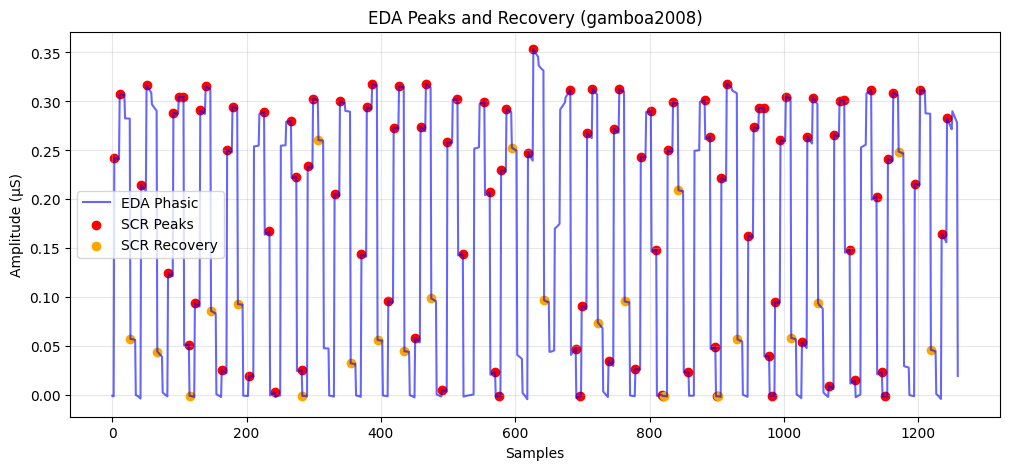

In [63]:
# STEP 6: Plot the detected peaks and recoveries
# ================================================================
plt.figure(figsize=(12, 5))
plt.plot(phasic_baseline_als, label="EDA Phasic", color="blue", alpha=0.6)

# Safely prepare peak indices (ensure integers and within bounds)
peaks_idx = np.asarray(info["SCR_Peaks"])
if peaks_idx.dtype.kind != "i":
	peaks_idx = peaks_idx.astype(int, copy=False)
valid_peaks_mask = (peaks_idx >= 0) & (peaks_idx < len(phasic_baseline_als))
peaks_idx = peaks_idx[valid_peaks_mask]
plt.scatter(peaks_idx, phasic_baseline_als[peaks_idx], color="red", label="SCR Peaks")

# Safely prepare recovery indices: remove NaNs and out-of-bounds values before casting
recovery_arr = np.asarray(info["SCR_Recovery"])
valid_recovery_mask = ~np.isnan(recovery_arr)
recovery_arr = recovery_arr[valid_recovery_mask]
if recovery_arr.size > 0:
	# ensure indices are integers and within bounds
	recovery_idx = recovery_arr.astype(int, copy=False)
	valid_recovery_mask2 = (recovery_idx >= 0) & (recovery_idx < len(phasic_baseline_als))
	recovery_idx = recovery_idx[valid_recovery_mask2]
	if recovery_idx.size > 0:
		plt.scatter(recovery_idx, phasic_baseline_als[recovery_idx], color="orange", label="SCR Recovery")

plt.title(f"EDA Peaks and Recovery ({method})")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µS)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

PEAK CORRECTION (eda_fixpeaks)

In [64]:
# STEP 3: Retrieve peaks, onsets, height (internal helper)
# Equivalent of _eda_fixpeaks_retrieve
original_input = info
peaks = _signal_formatpeaks_sanitize(original_input, key="Peaks")
onsets = _signal_formatpeaks_sanitize(original_input, key="Onsets")
height = _signal_formatpeaks_sanitize(original_input, key="Height")

In [65]:
# STEP 5: Prepare output
# ================================================================
fixed_info = {
    "SCR_Onsets": onsets,
    "SCR_Peaks": peaks,
    "SCR_Height": height
}

print(fixed_info)

{'SCR_Onsets': array([  10,   42,   50,   82,   90,   98,  100,  107,  122,  130,  138,
        162,  170,  178,  202,  208,  227,  235,  243,  267,  275,  290,
        298,  330,  338,  370,  378,  386,  410,  418,  426,  450,  458,
        466,  490,  498,  506,  515,  523,  555,  563,  571,  578,  586,
        618,  626,  651,  683,  691,  698,  706,  714,  738,  746,  754,
        778,  786,  791,  803,  811,  819,  826,  834,  855,  859,  883,
        891,  899,  906,  914,  946,  954,  962,  966,  971,  979,  986,
        994, 1002, 1026, 1034, 1042, 1066, 1074, 1082, 1084, 1091, 1099,
       1107, 1131, 1139, 1147, 1154, 1162, 1194, 1202, 1234, 1242, 1250]), 'SCR_Peaks': array([   3,   11,   43,   51,   83,   91,   99,  106,  114,  123,  131,
        139,  163,  171,  179,  203,  226,  234,  242,  266,  274,  282,
        291,  299,  331,  339,  371,  379,  387,  411,  419,  427,  451,
        459,  467,  491,  499,  514,  522,  554,  562,  570,  576,  579,
        587,  619,  6